# Iceberg Cosine Figures
Make tables related to the performance of ICEBERG on cosine similarity

In [47]:
from pathlib import Path
import pandas as pd
import numpy as np
import yaml
from ms_pred.common.plot_utils import *
set_style()

In [48]:
dataset_names = ["nist20", "canopus_train_public"]

# Define 
# data_folder = Path(f"../data/spec_datasets/{dataset_name}/")
# labels = data_folder / "labels.tsv"
results_folder = Path("../results/figs_iceberg/")

In [28]:
names = [
        "CFM-ID",
        "3DMolMS",
        "FixedVocab",
        "NEIMS (FFN)",
        "NEIMS (GNN)",
        "MassFormer",
        "SCARF", 
        "ICEBERG"
    ]
dataset_to_res = {}
for dataset_name in dataset_names:
    results_files = [
        f"../results/cfm_id_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/molnetms_baseline_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/graff_ms_baseline_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/ffn_baseline_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/gnn_baseline_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/massformer_baseline_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/scarf_inten_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/dag_inten_{dataset_name}/split_1/preds/pred_eval.yaml",
    ]

    yaml_files = {i: yaml.safe_load(open(j, "r")) for i, j in zip(names, results_files)}
    dataset_to_res[dataset_name] = yaml_files


for dataset_name in ["nist20"]:
    results_files = [
        f"../results/cfm_id_{dataset_name}/scaffold_1/preds/pred_eval.yaml",
        f"../results/molnetms_baseline_{dataset_name}/scaffold_1/preds/pred_eval.yaml",
        f"../results/graff_ms_baseline_{dataset_name}/scaffold_1/preds/pred_eval.yaml",
        f"../results/ffn_baseline_{dataset_name}/scaffold_1/preds/pred_eval.yaml",
        f"../results/gnn_baseline_{dataset_name}/scaffold_1/preds/pred_eval.yaml",
        f"../results/massformer_baseline_{dataset_name}/scaffold_1/preds/pred_eval.yaml",
        f"../results/scarf_inten_{dataset_name}/scaffold_1/preds/pred_eval.yaml",
        f"../results/dag_inten_{dataset_name}/scaffold_1/preds/pred_eval.yaml",
    ]

    yaml_files = {i: yaml.safe_load(open(j, "r")) for i, j in zip(names, results_files)}
    dataset_to_res[f"scaffold_{dataset_name}"] = yaml_files



In [29]:
name_to_time = {
    "CFM-ID": "../results/cfm_id_nist20_timer/time_out.json", 
    "3DMolMS": "../results/molnetms_baseline_nist20/split_1/time_out.json",
    "FixedVocab": "../results/graff_ms_baseline_nist20/split_1/time_out.json",
    "NEIMS (FFN)": "../results/ffn_baseline_nist20/split_1/time_out.json",
    "NEIMS (GNN)": "../results/gnn_baseline_nist20/split_1/time_out.json",
    "MassFormer": "../results/massformer_baseline_nist20/split_1/time_out.json",
    "SCARF": "../results/scarf_inten_nist20/split_1/time_out.json",
    "ICEBERG": "../results/dag_inten_nist20/split_1/time_out.json"
}
name_to_seconds = {i: yaml.safe_load(open(j, "r"))["time (s)"] for i, j in name_to_time.items()}

In [30]:
out_df = []
for dataset_name, yaml_files in dataset_to_res.items():
    for k, v in yaml_files.items():
        new_entry = {
            "Method": k, 
            "Cosine sim. avg": v['avg_cos_sim'],
            "Cosine sim. sem": v['sem_cos_sim'],
            "Coverage avg": v["avg_coverage"],
            "Coverage sem": v["sem_coverage"],
            "Valid avg": v['avg_frac_valid'],
            "Valid sem": v['sem_frac_valid'],
            "Time (s) orig": name_to_seconds[k],
            "Dataset": dataset_name,

        }
        out_df.append(new_entry)
out_df = pd.DataFrame(out_df)


In [31]:
# rewrite cosine sim column with f"cos sim \pm cosine sem using list comprehension
out_df["Cosine sim."] = [fr"${i:.3f} \pm {j:.3f}$" for i, j in zip(out_df["Cosine sim. avg"], out_df["Cosine sim. sem"])]
# Rewrite coverage column with f"coverage \pm coverage sem using list comprehension
out_df["Coverage"] = [fr"${i:.3f} \pm {j:.3f}$" for i, j in zip(out_df["Coverage avg"], out_df["Coverage sem"])]
# Same for valid
out_df["Valid"] = [fr"${i:.2f} \pm {j:.3f}$" for i, j in zip(out_df["Valid avg"], out_df["Valid sem"])]
out_df["Time (s)"] = [fr"${i:.1f}$" for i in out_df["Time (s) orig"]]


In [32]:
# only build scaffold split and normal split for NIST

out_df_temp = out_df[out_df['Dataset'].isin(["nist20", "scaffold_nist20"])]
out_df_pivot = out_df_temp.pivot_table(index="Method", columns="Dataset", 
                                       values=["Cosine sim.", ], 
                                       aggfunc=lambda x: x)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = ["Cosine sim."]
dataset_order = ["nist20", "scaffold_nist20"]

# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product([dataset_order, metric_order], names=['Dataset', 'Metric'])

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]


# Sort columns and make time last

out_df_pivot_sorted.index.name = None
latex = out_df_pivot_sorted.to_latex(caption="Comparing NIST scaffold vs. random spllit cosine similarity", 
                                     label="tab:scaffold",
                                     escape=False)
print(latex)

\begin{table}
\centering
\caption{Comparing NIST scaffold vs. random spllit cosine similarity}
\label{tab:scaffold}
\begin{tabular}{lll}
\toprule
Dataset &             nist20 &    scaffold_nist20 \\
{} &        Cosine sim. &        Cosine sim. \\
\midrule
CFM-ID      &  $0.371 \pm 0.004$ &  $0.401 \pm 0.003$ \\
3DMolMS     &  $0.508 \pm 0.004$ &  $0.466 \pm 0.003$ \\
FixedVocab  &  $0.587 \pm 0.004$ &  $0.558 \pm 0.003$ \\
NEIMS (FFN) &  $0.614 \pm 0.004$ &  $0.548 \pm 0.003$ \\
NEIMS (GNN) &  $0.689 \pm 0.003$ &  $0.639 \pm 0.003$ \\
MassFormer  &  $0.713 \pm 0.003$ &  $0.675 \pm 0.003$ \\
SCARF       &  $0.713 \pm 0.003$ &  $0.665 \pm 0.003$ \\
ICEBERG     &  $0.707 \pm 0.003$ &  $0.691 \pm 0.003$ \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_3866525/4036324257.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted.to_latex(caption="Comparing NIST scaffold vs. random spllit cosine similarity",


In [33]:
out_df_pivot = out_df.pivot_table(index="Method", 
                                  columns="Dataset", 
                                  values=["Cosine sim.", "Coverage",  "Valid", "Time (s)",],
                                    aggfunc=lambda x: x) 
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = {"Cosine sim.": 1, "Coverage": 2, "Valid": 3, "Time (s)": 4}
metric_order = ["Cosine sim.", "Coverage", "Valid", "Time (s)"]
dataset_order = {"nist20": 2, "canopus_train_public": 1, "scaffold_nist20": 3}
dataset_order = ["canopus_train_public", "nist20", "scaffold_nist20"]

# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product([dataset_order, metric_order], names=['Dataset', 'Metric'])

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]
out_df_pivot_sorted = out_df_pivot_sorted.drop(columns = [('canopus_train_public', "Time (s)"),
                                                          ('nist20', "Time (s)")])

# Sort columns and make time last
out_df_pivot_sorted.index.name = None
latex = out_df_pivot_sorted.to_latex(caption="Spectra prediction accuracy", 
                                     label="tab:spec_acc",
                                     escape=False)
print(latex)

\begin{table}
\centering
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{lllllllllll}
\toprule
Dataset & \multicolumn{3}{l}{canopus_train_public} & \multicolumn{3}{l}{nist20} & \multicolumn{4}{l}{scaffold_nist20} \\
{} &          Cosine sim. &           Coverage &             Valid &        Cosine sim. &           Coverage &             Valid &        Cosine sim. &           Coverage &             Valid &  Time (s) \\
\midrule
CFM-ID      &    $0.368 \pm 0.008$ &  $0.232 \pm 0.005$ &  $1.00 \pm 0.000$ &  $0.371 \pm 0.004$ &  $0.273 \pm 0.003$ &  $1.00 \pm 0.000$ &  $0.401 \pm 0.003$ &  $0.271 \pm 0.003$ &  $1.00 \pm 0.000$ &  $1114.7$ \\
3DMolMS     &    $0.394 \pm 0.009$ &  $0.507 \pm 0.008$ &  $0.92 \pm 0.003$ &  $0.508 \pm 0.004$ &  $0.731 \pm 0.004$ &  $0.95 \pm 0.002$ &  $0.466 \pm 0.003$ &  $0.709 \pm 0.003$ &  $0.97 \pm 0.001$ &     $3.4$ \\
FixedVocab  &    $0.479 \pm 0.008$ &  $0.548 \pm 0.007$ &  $1.00 \pm 0.000$ &  $0.587 \pm 0.004$ &  $0.749 \pm 0

/tmp/ipykernel_3866525/1738895141.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted.to_latex(caption="Spectra prediction accuracy",


In [49]:
out_df_pivot_sorted_temp = out_df_pivot_sorted.copy().drop(columns = [('canopus_train_public')])
latex = out_df_pivot_sorted_temp.to_latex(caption="Spectra prediction accuracy", 
                                     label="tab:spec_acc_nist_all",
                                     escape=False)
print(latex)

\begin{table}
\centering
\caption{Spectra prediction accuracy}
\label{tab:spec_acc_nist_all}
\begin{tabular}{llllllll}
\toprule
Dataset & \multicolumn{3}{l}{nist20} & \multicolumn{4}{l}{scaffold_nist20} \\
{} &        Cosine sim. &           Coverage &             Valid &        Cosine sim. &           Coverage &             Valid &  Time (s) \\
\midrule
CFM-ID      &  $0.371 \pm 0.004$ &  $0.273 \pm 0.003$ &  $1.00 \pm 0.000$ &  $0.401 \pm 0.003$ &  $0.271 \pm 0.003$ &  $1.00 \pm 0.000$ &  $1114.7$ \\
3DMolMS     &  $0.508 \pm 0.004$ &  $0.731 \pm 0.004$ &  $0.95 \pm 0.002$ &  $0.466 \pm 0.003$ &  $0.709 \pm 0.003$ &  $0.97 \pm 0.001$ &     $3.4$ \\
FixedVocab  &  $0.587 \pm 0.004$ &  $0.749 \pm 0.004$ &  $1.00 \pm 0.000$ &  $0.558 \pm 0.003$ &  $0.751 \pm 0.003$ &  $1.00 \pm 0.000$ &     $4.1$ \\
NEIMS (FFN) &  $0.614 \pm 0.004$ &  $0.739 \pm 0.004$ &  $0.95 \pm 0.001$ &  $0.548 \pm 0.003$ &  $0.719 \pm 0.003$ &  $0.97 \pm 0.001$ &     $3.4$ \\
NEIMS (GNN) &  $0.689 \pm 0.003$ &  $0.

/tmp/ipykernel_3866525/265104993.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted_temp.to_latex(caption="Spectra prediction accuracy",


In [50]:
out_df_pivot_sorted_temp  = out_df_pivot_sorted.copy().drop(columns = ['scaffold_nist20', "nist20"])
latex = out_df_pivot_sorted_temp.to_latex(caption="Spectra prediction accuracy", 
                                     label="tab:spec_acc_gnps",
                                     escape=False)
print(latex)

\begin{table}
\centering
\caption{Spectra prediction accuracy}
\label{tab:spec_acc_gnps}
\begin{tabular}{llll}
\toprule
Dataset & \multicolumn{3}{l}{canopus_train_public} \\
{} &          Cosine sim. &           Coverage &             Valid \\
\midrule
CFM-ID      &    $0.368 \pm 0.008$ &  $0.232 \pm 0.005$ &  $1.00 \pm 0.000$ \\
3DMolMS     &    $0.394 \pm 0.009$ &  $0.507 \pm 0.008$ &  $0.92 \pm 0.003$ \\
FixedVocab  &    $0.479 \pm 0.008$ &  $0.548 \pm 0.007$ &  $1.00 \pm 0.000$ \\
NEIMS (FFN) &    $0.494 \pm 0.008$ &  $0.528 \pm 0.007$ &  $0.95 \pm 0.002$ \\
NEIMS (GNN) &    $0.520 \pm 0.008$ &  $0.552 \pm 0.008$ &  $0.94 \pm 0.003$ \\
MassFormer  &    $0.565 \pm 0.008$ &  $0.564 \pm 0.007$ &  $0.96 \pm 0.002$ \\
SCARF       &    $0.534 \pm 0.008$ &  $0.553 \pm 0.008$ &  $1.00 \pm 0.000$ \\
ICEBERG     &    $0.628 \pm 0.008$ &  $0.544 \pm 0.007$ &  $1.00 \pm 0.000$ \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_3866525/197557571.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted_temp.to_latex(caption="Spectra prediction accuracy",


In [34]:
method_colors

{'Random': '#808080',
 'CFM-ID': '#C2AF53',
 '3DMolMS': '#A56F8F',
 'MassFormer': '#4C0027',
 'FixedVocab': '#41644A',
 'NEIMS (FFN)': '#B94346',
 'NEIMS (GNN)': '#DB8F76',
 'SCARF': '#479394',
 'ICEBERG': '#3D4A9F'}

/tmp/ipykernel_3866525/1338173279.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(method_names, rotation=45, ha="right")


[Text(0, 0, 'CFM-ID'),
 Text(1, 0, '3DMolMS'),
 Text(2, 0, 'FixedVocab'),
 Text(3, 0, 'NEIMS (FFN)'),
 Text(4, 0, 'NEIMS (GNN)'),
 Text(5, 0, 'MassFormer'),
 Text(6, 0, 'SCARF'),
 Text(7, 0, 'ICEBERG')]

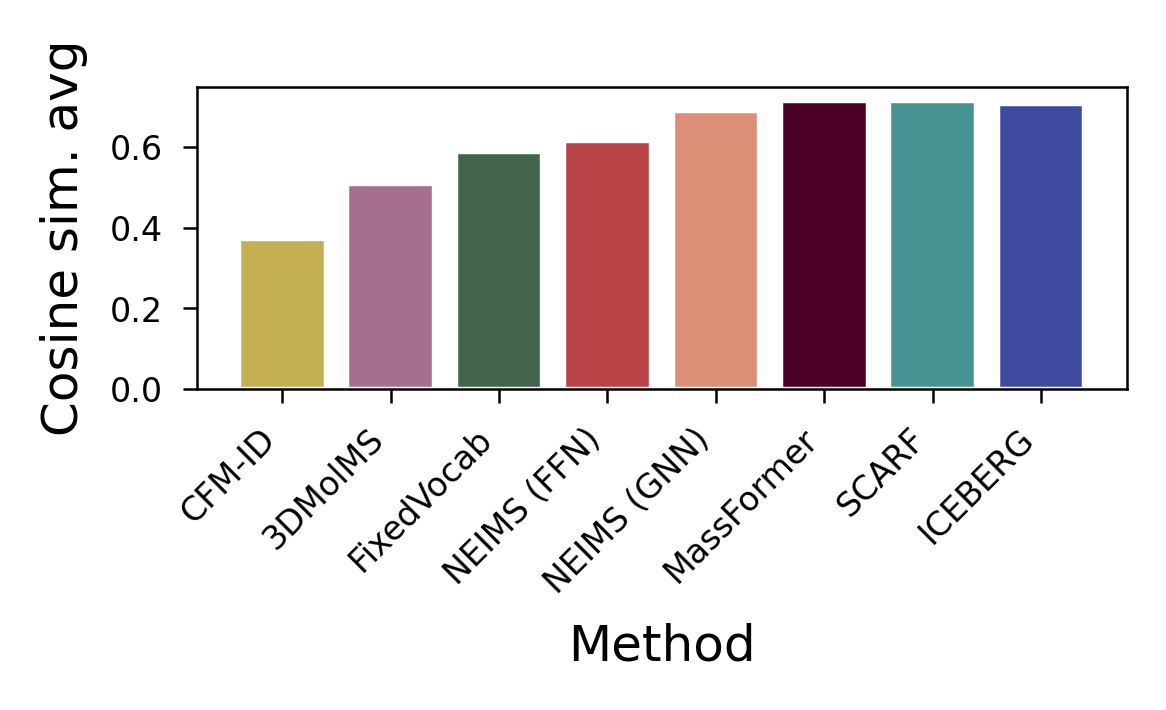

In [52]:
## Define Cosine sim bar plots

dataset = "nist20"
dataset_sub = out_df[['Method', 'Cosine sim. avg', 'Cosine sim. sem',  'Dataset']].query(f"Dataset == '{dataset}'")
dataset_sub.set_index("Method", inplace=True)
fig = plt.figure(figsize=(3,1), dpi=400)

ax = fig.gca()
dataset_sub = dataset_sub.loc[names]
sim = dataset_sub[['Cosine sim. avg']].values.flatten()
method_names  = dataset_sub.index.values

ax.bar(method_names, sim, color=[method_colors[i] for i in method_names])
ax.set_ylabel("Cosine sim. avg")
ax.set_xlabel("Method")
# Rotate x tick labels
ax.set_xticklabels(method_names, rotation=45, ha="right")

/tmp/ipykernel_3866525/3551833020.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(method_names, rotation=90, ha="center")
/tmp/ipykernel_3866525/3551833020.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(method_names, rotation=90, ha="center")
/tmp/ipykernel_3866525/3551833020.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(method_names, rotation=90, ha="center")


[1114.6517303     3.4471314     4.14904714    3.43894839    4.32771897
    7.83326101   21.45809102  117.49996352]


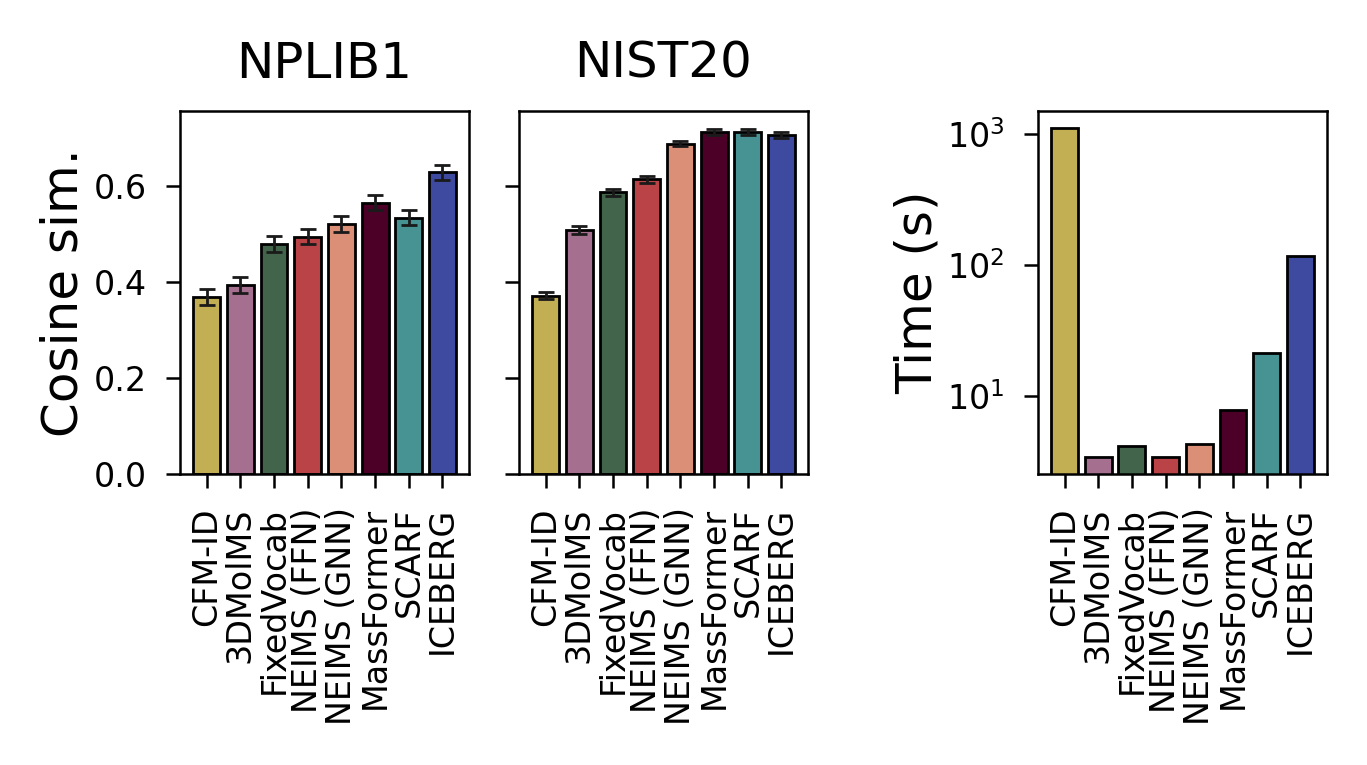

In [57]:
# Plot cosine similarities and time for 2 datasets
# define subplots
gridspec = dict(hspace=0.0, width_ratios=[1, 1, 0.45, 1])
fig, axes = plt.subplots(1, 4, figsize=(3.7, 1.2), dpi=400, sharey=False, gridspec_kw=gridspec)
plt_dataset_names = {"canopus_train_public": "NPLIB1", "nist20": "NIST20"}

plot_datasets = ["canopus_train_public", "nist20",]
for ind, (ax, dataset) in enumerate(zip(axes, plot_datasets)):

    dataset_sub = out_df[['Method', 'Cosine sim. avg', 'Cosine sim. sem', 'Dataset']].query(f"Dataset == '{dataset}'")
    dataset_sub.set_index("Method", inplace=True)
    dataset_sub = dataset_sub.loc[names]
    sim = dataset_sub[['Cosine sim. avg']].values.flatten()
    sem = dataset_sub[['Cosine sim. sem']].values.flatten()

    # Using sem compute 95% confidence interval and plot error bars
    ci = sem * 1.96

    method_names  = dataset_sub.index.values

    ax.bar(method_names, sim, color=[method_colors[i] for i in method_names],
              edgecolor="black", linewidth=0.5, 
              yerr=ci, capsize=1.5, 
              error_kw=dict(lw=0.5, capsize=1.5, capthick=0.5)
              )
    if ind == 0:
        ax.set_ylabel("Cosine sim.")
    # ax.set_xlabel("Method")
    # Rotate x tick labels
    ax.set_xticklabels(method_names, rotation=90, ha="center")
    ax.set_title(plt_dataset_names.get(dataset))
    ax.yaxis.labelpad = 1

axes[0].get_shared_y_axes().join(axes[0], axes[1])
axes[1].set_yticklabels([])
axes[2].set_visible(False)

ax = axes[3]
dataset_sub = out_df[['Method', 'Dataset', 'Time (s) orig']].query(f"Dataset == '{dataset}'")
dataset_sub.set_index("Method", inplace=True)
dataset_sub = dataset_sub.loc[names]
time = dataset_sub[['Time (s) orig']].values.flatten()
print(time)
method_names  = dataset_sub.index.values

ax.bar(method_names, time, color=[method_colors[i] for i in method_names], 
       edgecolor="black", linewidth=0.5)

# Remove padding from  y label
ax.set_ylabel("Time (s)", )
ax.yaxis.labelpad = 1
ax.set_yscale("log")
# ax.set_xlabel("Method")
# Rotate x tick labels
ax.set_xticklabels(method_names, rotation=90, ha="center")

# Remove y minor ticks
ax.yaxis.set_minor_locator(plt.NullLocator())

# Space 3rd plot further from others
# fig.tight_layout()


# Save fig to file
fig.savefig(results_folder / "cosine_time_barplot.pdf", bbox_inches="tight", transparent=True)

In [9]:
# out_df = out_df.set_index(["Method", "Dataset"]).round(3)
# out_df.index.name = None
# latex = out_df.to_latex(caption="Spectra prediction accuracy", label="tab:spec_acc")
# print(latex)

## Analyzing the differences between datasets

In [9]:
### Randomly sample 10 molecules and draw them
import random
labels_canopus = "../data/spec_datasets/canopus_train_public/labels.tsv"
labels_nist = "../data/spec_datasets/nist20/labels.tsv"

df_1 = pd.read_csv(labels_canopus, sep="\t")
df_2 = pd.read_csv(labels_nist, sep="\t")

for data_name, df in zip(["canopus", "nist"], [df_1,df_2]): 
    sub_folder = results_folder / f"mol_examples/{data_name}"
    sub_folder.parent.mkdir(exist_ok=True)
    sub_folder.mkdir(exist_ok=True)

    random.seed(2)
    np.random.seed(2)

    with open(sub_folder / f"mol_smis.txt", "w") as fp:
        for i in range(10):
            smi = random.choice(df["smiles"].values)
            mol = Chem.MolFromSmiles(smi)
            img = Draw.MolToImage(mol, size=(200, 200))
            img.save(sub_folder / f"mol_{i}.png")
            fp.write(f"{smi}\t{i}\n")

<module 'tdc' from '/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tdc/__init__.py'>

1.699621281696647

In [12]:
import tdc
from rdkit.Chem import Descriptors
oracle = tdc.oracles.Oracle(name="SA")
from ms_pred import common



def calc_molweight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol)




name_to_weights = {}
for data_name, df in zip(["canopus", "nist"], [df_1,df_2]): 
    mol_weights = common.chunked_parallel(df['smiles'].values, calc_molweight)
    name_to_weights[data_name] = mol_weights


name_to_sa = {}
for data_name, df in zip(["canopus", "nist"], [df_1,df_2]): 
    sa_score = common.chunked_parallel(df['smiles'].values, lambda x: oracle(x))
    name_to_sa[data_name] = sa_score



  0%|          | 0/101 [00:00<?, ?it/s]Found local copy...
Found local copy...
Found local copy...Found local copy...

Found local copy...
Found local copy...
Found local copy...
Found local copy...
Found local copy...Found local copy...

Found local copy...Found local copy...

Found local copy...
Found local copy...
Found local copy...
Found local copy...
100%|██████████| 101/101 [00:00<00:00, 102.42it/s]
Found local copy...
Found local copy...
Found local copy...
Found local copy...Found local copy...Found local copy...


Found local copy...
Found local copy...
Found local copy...
Found local copy...
Found local copy...
Found local copy...Found local copy...
Found local copy...
  0%|          | 0/101 [00:00<?, ?it/s]
Found local copy...Found local copy...

100%|██████████| 101/101 [00:02<00:00, 50.38it/s]


In [25]:
print({i: np.mean(j) for i, j  in name_to_sa.items()})
print({i: np.mean(j) for i, j  in name_to_weights.items()})

{'canopus': 3.7522641916419297, 'nist': 3.014947602506307}
{'canopus': 412.7486759734804, 'nist': 316.8960129237952}


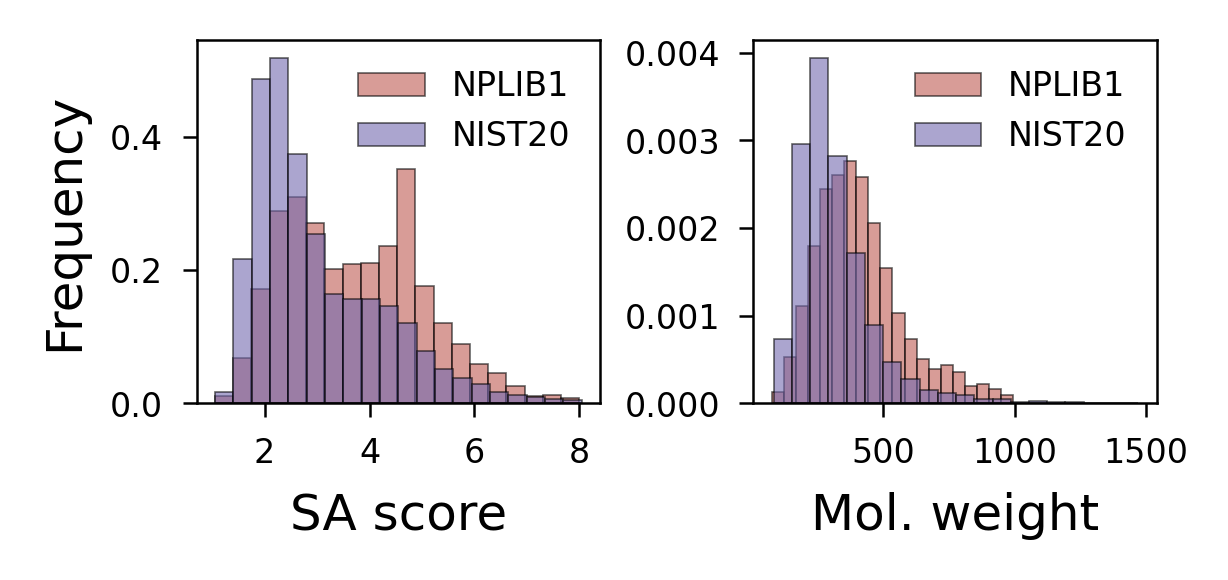

In [26]:
# Plot distributions of SA score and molecular weight
# define subplots
gridspec = dict(hspace=0.0, width_ratios=[1, 0.1, 1])
fig, axes = plt.subplots(1, 3, figsize=(3.8, 1.2), dpi=400, sharey=False, 
                         gridspec_kw=gridspec)
plt_dataset_names = {"canopus": "NPLIB1", "nist": "NIST20"}

dataset_colors = {"nist": "#7369AF", "canopus": "#BF5A52"}
alpha = 0.6
ax = axes[0]

for plt_dataset_name in plt_dataset_names:
    ax.hist(name_to_sa[plt_dataset_name], bins=20, density=True, 
            color=dataset_colors[plt_dataset_name], 
            label=plt_dataset_names[plt_dataset_name], alpha=alpha, 
            edgecolor="black", linewidth=0.3)
ax.set_xlabel("SA score")
ax.set_ylabel("Frequency")
ax.legend(**legend_params)


axes[1].set_visible(False)

ax = axes[2]
for plt_dataset_name in plt_dataset_names:
    ax.hist(name_to_weights[plt_dataset_name], bins=20, density=True, 
            color=dataset_colors[plt_dataset_name],
            label=plt_dataset_names[plt_dataset_name], alpha=alpha,
            edgecolor="black", linewidth=0.3
            )
ax.set_xlabel("Mol. weight")
# ax.set_ylabel("Frequency")
ax.legend(**legend_params)
set_size(2.4, 0.908, ax)

fig.savefig(results_folder / "sa_molweight_hist.pdf", bbox_inches="tight", transparent=True)
